In [2]:
pip install speechbrain

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchmetrics asteroid

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers torchaudio

Note: you may need to restart the kernel to use updated packages.


before featureextractor
after featureextractor


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


after model Wav2Vec2
VoxCeleb datasets loaded from local storage.
in evaluate_speaker_verification
total files: 34
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00008.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00007.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00002.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00004.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00006.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00003.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00001.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/dkN2DIBrXqQ/00005.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/BlqlndM-quU/00001.wav
in file process: /kaggle/input/vox1smallsize/vox1 copy/wav/id10272/0qqQJVFKpbA/00002

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


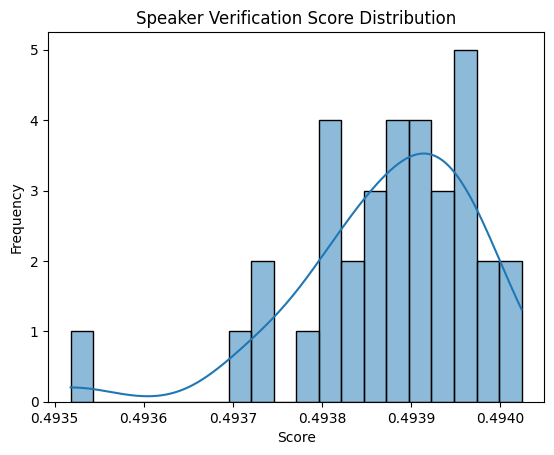

before mixed Audio
after mixed Audio
before separate


/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

after separate


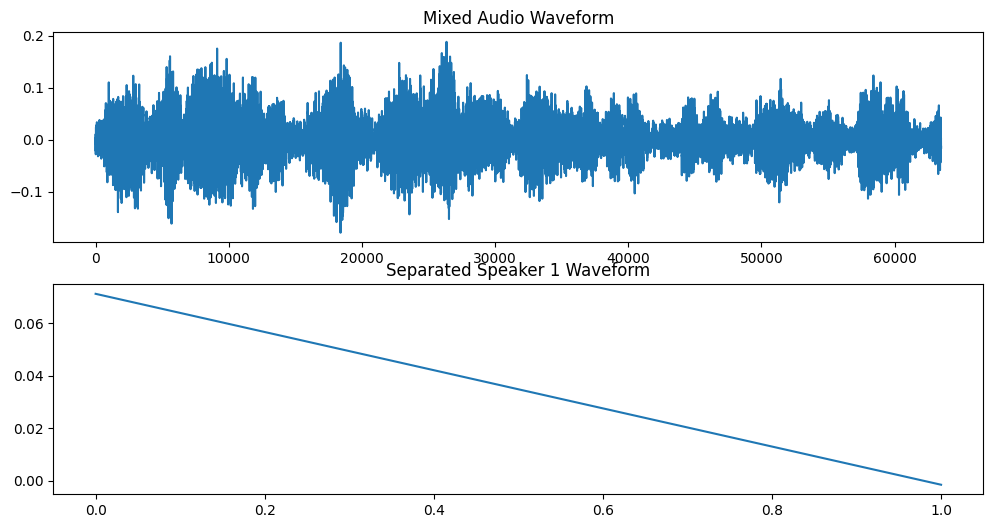

before finetune
after finetune
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Fine-tuning complete.


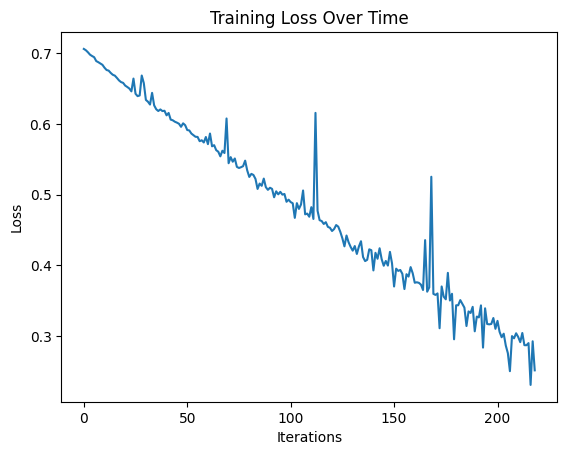

Pipeline execution complete.


In [5]:
import os
import torchaudio
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch
import numpy as np
from speechbrain.pretrained import SepformerSeparation as SepFormer
from transformers import Trainer, TrainingArguments
from torch.optim import Adam
import torch.nn.functional as F
from torchmetrics.classification import BinaryAUROC



# Use GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load VoxCeleb1 and VoxCeleb2 from local storage
def load_voxceleb1():
    base_path = "/kaggle/input/vox1smallsize/vox1 copy/wav"
    files = glob.glob(os.path.join(base_path, "**", "*.wav"), recursive=True)
    if not files:
        print("Warning: No audio files found in VoxCeleb1!")
    return files

def load_voxceleb2():
    base_path = "/kaggle/input/tempdbkagglevox1/vox2 copy/aac"
    files = glob.glob(os.path.join(base_path, "**", "*.m4a"), recursive=True)
    if not files:
        print("Warning: No audio files found in VoxCeleb2!")
    return files

# Step 2: Load Pre-trained Speaker Verification Model
def load_speaker_verification_model():
    model_name = "facebook/wav2vec2-large-xlsr-53"
    print("before featureextractor")
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    print("after featureextractor")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)
    print("after model Wav2Vec2")
    return feature_extractor, model

# Step 3: Evaluate Speaker Verification Model
def evaluate_speaker_verification(model, feature_extractor, files):
    if not files:
        print("No files to evaluate. Skipping speaker verification.")
        return
    
    print("in evaluate_speaker_verification")
    scores = []
    labels = []
    
    print("total files:", len(files))
    for i, file in enumerate(files):
        print("in file process:", file)
        audio, sr = torchaudio.load(file)
        inputs = feature_extractor(audio.squeeze().numpy(), return_tensors="pt", sampling_rate=sr)
        with torch.no_grad():
            logits = model(**inputs).logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            scores.append(probabilities[:, 1].item())
            labels.append(i % 2)
    
    if not scores or not labels:
        print("No valid predictions. Skipping AUROC calculation.")
        return
    
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int)
    
    print("before BinaryAUROC - scores", len(scores_tensor), scores_tensor)
    print("before BinaryAUROC - labels", len(labels_tensor), labels_tensor)
    auroc = BinaryAUROC()(scores_tensor, labels_tensor)
    print("after BinaryAUROC")
    eer = 1 - auroc.item()
    print(f"Equal Error Rate (EER): {eer:.2f}%")
    print(f"TAR@1%FAR (approx AUROC): {auroc:.2f}")

    # Plot AUROC scores
    sns.histplot(scores, bins=20, kde=True)
    plt.title("Speaker Verification Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()


# Step 4: Create Multi-Speaker Scenario
def mix_speakers(files, num_speakers=2):
    if len(files) < num_speakers:
        print("Not enough files to mix speakers. Skipping.")
        return []
    
    print("before mixed Audio")
    mixed_audio = []
    min_length = min([torchaudio.load(f)[0].shape[1] for f in files])
    
    for i in range(0, len(files) - num_speakers, num_speakers):
        audio_samples = []
        for j in range(num_speakers):
            audio, _ = torchaudio.load(files[i + j])
            audio = audio[:, :min_length]
            audio_samples.append(audio)
        mixed_audio.append(sum(audio_samples) / num_speakers)
    
    print("after mixed Audio")
    return mixed_audio

# Step 5: Speaker Separation with SepFormer
def separate_speakers(audio_mixture):
    if not audio_mixture:
        print("No mixed audio available. Skipping separation.")
        return []
    
    print("before separate")
    model = SepFormer.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir="sepformer")
    
    audio_mixture = torch.stack(audio_mixture).squeeze(1).to(model.device)
    separated = model.separate_batch(audio_mixture)
    print("after separate")

    # Plot mixed and separated waveforms
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(audio_mixture.cpu().numpy()[0])
    plt.title("Mixed Audio Waveform")
    
    plt.subplot(2, 1, 2)
    plt.plot(separated.cpu().numpy()[0][0])
    plt.title("Separated Speaker 1 Waveform")
    plt.show()
    return separated

# Step 6: Fine-tune and Integrate Speaker Verification Model
def fine_tune_model(model, files, feature_extractor):
    if not files:
        print("No files for fine-tuning. Skipping.")
        return
    
    print("before finetune")
    optimizer = Adam(model.parameters(), lr=1e-5)
    model.train()
    print("after finetune")
    losses = []
    for epoch in range(3):
        for file in files:
            audio, sr = torchaudio.load(file)
            inputs = feature_extractor(audio.squeeze().numpy(), return_tensors="pt", sampling_rate=sr)
            labels = torch.tensor([1]).long()
            
            optimizer.zero_grad()
            logits = model(**inputs).logits
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {epoch+1} completed")
    print("Fine-tuning complete.")

    # Plot training loss
    plt.plot(losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

if __name__ == "__main__":
    vox1_files = load_voxceleb1()
    vox2_files = load_voxceleb2()
    feature_extractor, model = load_speaker_verification_model()
    print("VoxCeleb datasets loaded from local storage.")
    
    evaluate_speaker_verification(model, feature_extractor, vox1_files)
    mixed_audio = mix_speakers(vox2_files)
    separated_audio = separate_speakers(mixed_audio)
    fine_tune_model(model, vox2_files, feature_extractor)
    print("Pipeline execution complete.")
